## TP6-  Learning a non-linear function

(https://hastie.su.domains/ISLP/ISLP_website.pdf - Chp7)


In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
from patsy import bs, dmatrix
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

### Example: Wages Dataset

This is a data of wages of the employees of a company briefing about the salary with respect to the relevant detailing. With different exploratory analysis methods, lets predict the conclusion from the given data set.

In [38]:
Wages = pd.read_csv('Wage.csv')
Wages.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [39]:
# rename the 'Unnamed: 0' col to 'id'
Wages = Wages.rename(columns={'Unnamed: 0': 'id'})

# find out if there are any missing values
print(pd.isnull(Wages).any())

year          False
age           False
maritl        False
race          False
education     False
region        False
jobclass      False
health        False
health_ins    False
logwage       False
wage          False
dtype: bool


## Polynomial Regression 


In [40]:
model = smf.ols('wage ~ age + I(age**2)+ I(age**3) + I(age**4)', data=Wages)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           2.77e-57
Time:                        16:21:57   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -184.1542     60.040     -3.067      

## Predictions

We now make out-of-sample predictions and get the standard errors of the predictions (i.e. Confidence Interval for the mean).

In [41]:
# construct an array of ages to predict the wage for.
new_ages = np.linspace(Wages.age.min(), Wages.age.max(), num=1000)
# make the predictions using the predict method for the estimate
predictions = estimate.predict(exog=dict(age = new_ages))

# call the summary table at a (1-alpha)100% confidence interval level.
# This method returns back data an array with standard errors and confidence intervals
simpleTable, data, column_names = summary_table(estimate, alpha=0.05)

# Data contains the confidence intervals we want but we need to make sure we get the right
# columns so lets print off the names
print('column_names: ', column_names)

# Get confidence intervals for a given x. These correspond to columns 4 and 5. Note columns 6 and 7 are
# the prediction intervals.
predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T

column_names:  ['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]


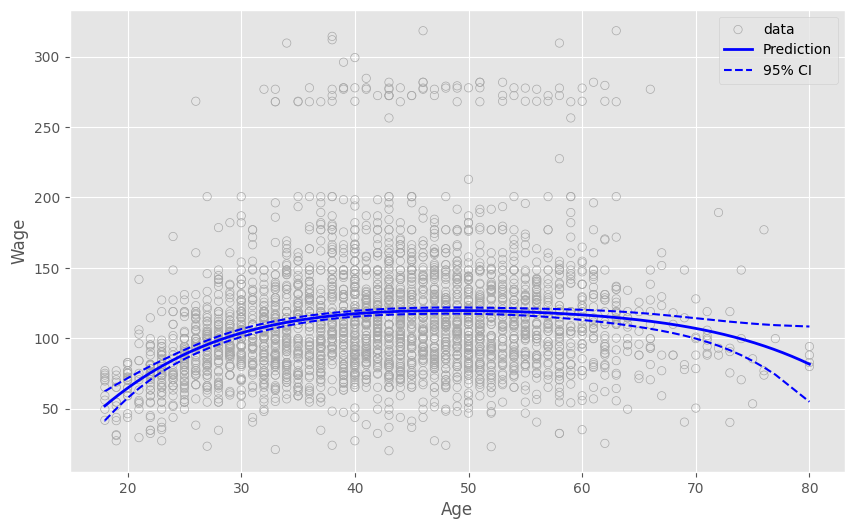

In [42]:
# Plot the data, the prediction and the 95% confidence intervals
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label="data")
ax.plot(new_ages,predictions, 'b-', lw=2, label='Prediction')

# sort the ages and use the order to sort the predicted values
order = np.argsort(Wages.age.values)
ax.plot(Wages.age.values[order], predicted_mean_ci_low[order], 'b--', label='95% CI')
ax.plot(Wages.age.values[order], predicted_mean_ci_high[order], 'b--')

ax.legend(loc='best');
ax.set_xlabel('Age');
ax.set_ylabel('Wage');

## ANOVA to Obtain Polynomial Degree

In ANOVA, we construct models for each order. Then we compare the models using $\frac{RSS_0-RSS}{q}/\frac{RSS}{n-p-1}$. Where $RSS_0$ is a reduced model with all but the last q coeffecients and RSS is the full model. The Null Hypothesis is $H_0: \beta_{p-q+1}=\beta_{p-q+2}=...=\beta_p = 0$. If the p-values for the model comparisons are small then we reject the null hypothesis and KEEP that particular coefficient. 

In [43]:
# make models up to order 5.
est1 = smf.ols('wage ~ age', data=Wages).fit()
est2 = smf.ols('wage ~ age + I(age**2)', data=Wages).fit()
est3 = smf.ols('wage ~ age + I(age**2)+ I(age**3)', data=Wages).fit()
est4 = smf.ols('wage ~ age + I(age**2)+ I(age**3) + I(age**4)', data=Wages).fit()
est5 = smf.ols('wage ~ age + I(age**2)+ I(age**3) + I(age**4) + I(age**5)', data=Wages).fit()

# note only works when using formula api
# call anova to compare the models
anova = sm.stats.anova_lm(est1,est2,est3,est4,est5)
print(anova)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


The p-value for the 1st-order to second order model is <2e-16, meaning that the quadratic term is significant and should be included. Similarly the second order to third order model has a p-value that is significant, so it should be included. The third to fourth order is just significant ~5% but the fourth to fifth order is not. So a fourth order model is indicated by the anova.

## Logistic Model of Wage

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


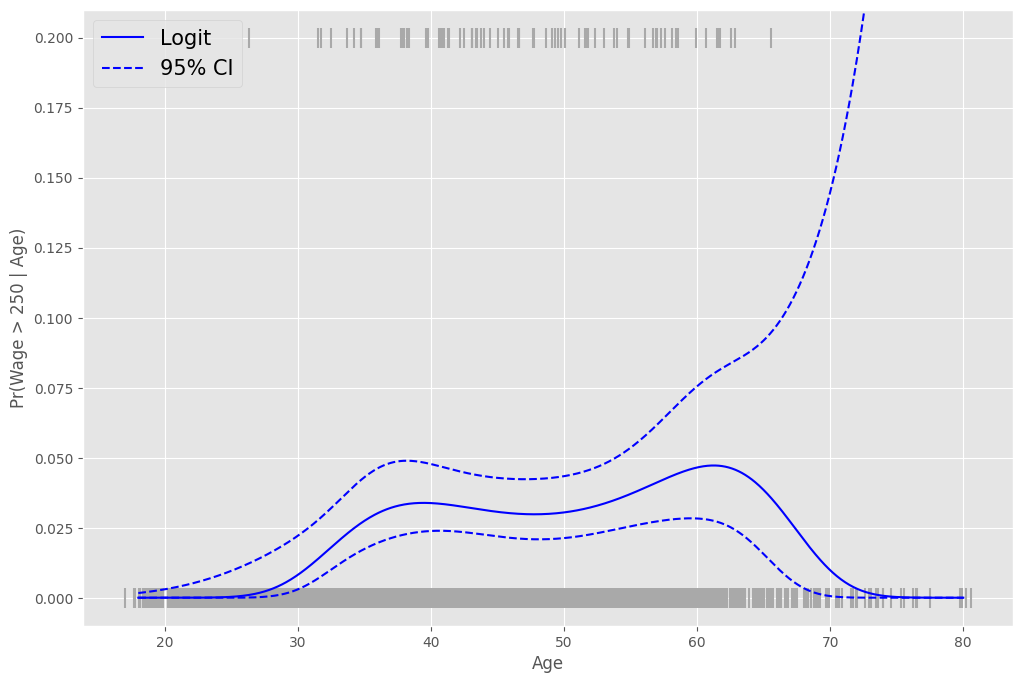

In [44]:
# Build Model #
###############
# We will predict the probability of a wage > 250k based on a fourth order polynomial of age using Logit func.
Wages['high_earner'] = (Wages.wage > 250).astype(float)
model = smf.logit('high_earner ~ age + I(age**2) + I(age**3) + I(age**4)', data=Wages)
# make fit
estimate = model.fit()
#print(estimate.summary())

# Make OOS Predictions #
########################
# construct an array of ages to predict the wage for.
new_ages = np.linspace(Wages.age.min(), Wages.age.max(), num=1000)
# make the predictions using the predict method for the estimate
predictions = estimate.predict(exog=dict(age=new_ages))

# Get CIs #
###########
# So for logit functions we don't get the CI for free. Recall the SE**2 = X.T * Sigma * X for a LINEAR model.
# Where X is (1,x_0,x_0**2, x_0**3, x_0**4) for each x_0 and Sigma is the covariance matrix. So we will compute the 
# linear model SE and transform it into logit function SE.
std_err = np.array([])
for age in new_ages:
    # construct the feature vector
    poly_age = np.array([[1,age,age**2,age**3,age**4]])
    temp = np.dot(estimate.cov_params(),poly_age.T)
    #compute the product to get linear model SE
    std_err = np.append(std_err, np.sqrt(np.dot(poly_age, temp)))
    
# Compute the critical value t_alpha/2,n-1 ~ alpha = 5%
crit_value = stats.t.isf(.05/2,len(Wages)-1)
# compute the confidence interval width
widths = crit_value*std_err
# compute the linear fit y_hats by asking predict to return linear=True
###linear_fit_vals = estimate.predict(exog=dict(age=new_ages), linear=True)

linear_fit_vals = estimate.predict(exog=dict(age=new_ages), which="linear")

# constuct upper and lower CIs
ui_linear = linear_fit_vals + widths
li_linear = linear_fit_vals - widths

# Transform the CIs under Logit 'link' function
ui = np.exp(ui_linear)/(1+np.exp(ui_linear))
li = np.exp(li_linear)/(1+np.exp(li_linear))

# Make plot
fig, ax = plt.subplots(figsize=(12,8))
# Function to randomly jitter the age data
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
# add the data to the plot
ax.scatter(rand_jitter(Wages.age.values), Wages.high_earner.values/5, marker='|', color='darkgray', s=200)
# add prediction curve
ax.plot(new_ages,predictions,color='b',label='Logit')
# add 95% CI
ax.plot(new_ages, ui, color='b', linestyle='--', label='95% CI')
ax.plot(new_ages, li, color= 'b', linestyle='--')
# Set plt axis params
ax.set_ylim([-.01,0.21]);
ax.set_xlabel('Age')
ax.set_ylabel('Pr(Wage > 250 | Age)');
plt.legend(loc='best', prop={'size':15});


In [45]:
################################# Specifying Locations of Knots ############################################

# Build Patsy Design Matrix #
#############################
# Build a design matrix for the age basis functions explicitly providing the knot locations
design = dmatrix("bs(age, knots=(25,40,60), degree=3, include_intercept=False)", data={"age":Wages.age}, 
                 return_type="dataframe")

# Fit Statsmodels GLM #
########################
model = sm.GLM(endog=Wages.wage, exog=design)
estimate = model.fit()

# Make Predictions #
####################
# now call the estimate on new values to create the predicted spline
age_grid = np.linspace(Wages.age.min(), Wages.age.max(), num=1000)
prediction_design = dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe')
predictions = estimate.predict(prediction_design)

# Get Prediction CI's #
#######################
std_err = np.array([])
for row in prediction_design.values:
    # This row is a polynomial of the spline basis functions
    t = np.dot(estimate.cov_params(), row.T)
    # compute X.T*Sigma*X to get SE**2 then we can use this to get CIs
    std_err = np.append(std_err,np.sqrt(np.dot(row, t)))
    
# Compute the critical value t_alpha/2,n-1 ~ alpha = 5%
crit_value = stats.t.isf(.05/2,len(Wages)-1)
# compute the confidence interval width
widths = crit_value*std_err

# constuct upper and lower CIs
ui = predictions + widths
li = predictions - widths

In [46]:
###################################### Specifying the DoF=6 (Degrees of Freedom) ########################################################
# Build a design matrix for the age basis functions 
design = dmatrix("bs(age, df=6, degree=3, include_intercept=False)", data={"age":Wages.age})

# Fit Statsmodels GLM #
########################
model2 = sm.GLM(endog=Wages.wage, exog=design)
estimate2 = model2.fit()

# Make Predictions #
####################
# now call the estimate on new values to create the predicted spline
prediction2_design = dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe')
predictions2 = estimate2.predict(prediction2_design)

# Get Prediction CI's #
#######################
std_err2 = np.array([])
for row in prediction2_design.values:
    # This row is a polynomial of the spline basis functions
    t = np.dot(estimate2.cov_params(), row.T)
    # compute X.T*Sigma*X to get SE**2 then we can use this to get CIs
    std_err2 = np.append(std_err2,np.sqrt(np.dot(row, t)))
    
# Compute the critical value t_alpha/2,n-1 ~ alpha = 5%
crit_value2 = stats.t.isf(.05/2,len(Wages)-1)
# compute the confidence interval width
widths2 = crit_value*std_err

# constuct upper and lower CIs
ui2 = predictions2 + widths2
li2 = predictions2 - widths2

In [47]:
########################################## Natural Spline DoF=4 ####################################################
# Build a design matrix for the age basis functions 
design3 = dmatrix("cr(age, df=4)", data={"age":Wages.age},return_type='dataframe')

# Fit Statsmodels GLM OR OLS #
##############################
model3 = sm.GLM(endog=Wages.wage, exog=design3)
estimate3 = model3.fit()

# Make Predictions #
####################
# now call the estimate on new values to create the predicted spline
prediction3_design = dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid},return_type='dataframe')
predictions3 = estimate3.predict(prediction3_design)

# Get Prediction CI's #
#######################
std_err3 = np.array([])
for row in prediction3_design.values:
    # This row is a polynomial of the spline basis functions
    t = np.dot(estimate3.cov_params(), row.T)
    # compute X.T*Sigma*X to get SE**2 then we can use this to get CIs
    std_err3 = np.append(std_err3,np.sqrt(np.dot(row, t)))
    
# Compute the critical value t_alpha/2,n-1 ~ alpha = 5%
crit_value3 = stats.t.isf(.05/2,len(Wages)-1)
# compute the confidence interval width
widths3 = crit_value*std_err

# constuct upper and lower CIs
ui3 = predictions3 + widths3
li3 = predictions3 - widths3

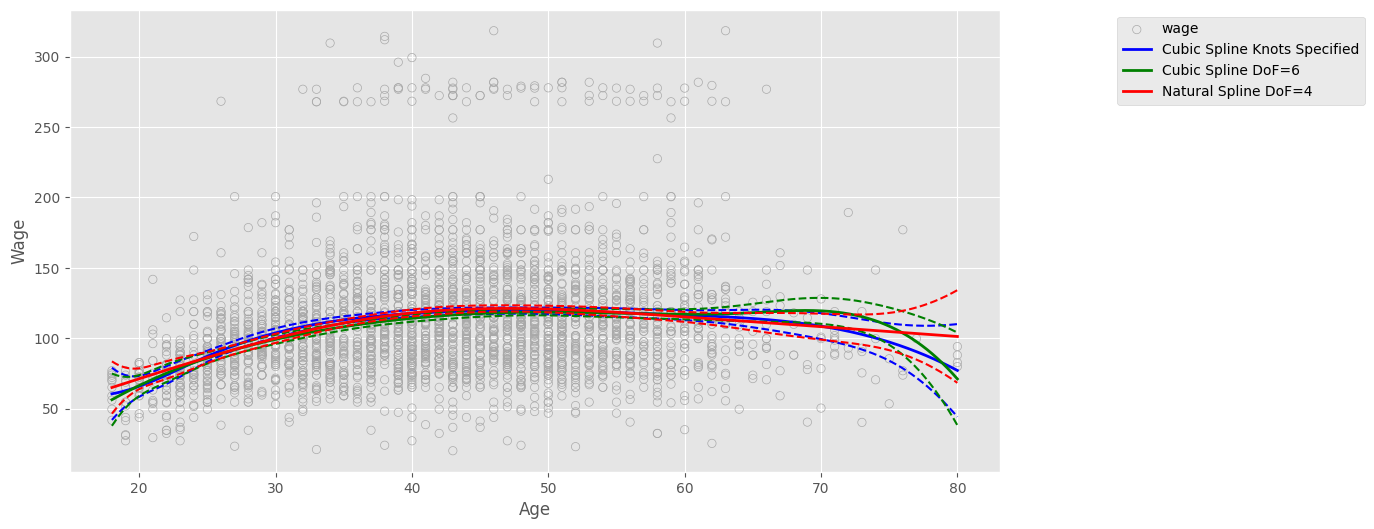

In [48]:
# Plot #
########
fig, ax = plt.subplots(1,1,figsize=(12,6))
# plot data 
ax.scatter(Wages.age, Wages.wage,facecolors='none', edgecolors='darkgray', label="wage");

# plot the prediction when knots are specified
ax.plot(age_grid, predictions, 'b-', lw=2, label='Cubic Spline Knots Specified');
# add 95% CI
ax.plot(age_grid, ui, color='b', linestyle='--');
ax.plot(age_grid, li, color= 'b', linestyle='--');

# plot the prediction when the dof is specified
ax.plot(age_grid, predictions2, 'g-', lw=2, label='Cubic Spline DoF=6');
# add 95% CI
ax.plot(age_grid, ui2, color='g', linestyle='--');
ax.plot(age_grid, li2, color= 'g', linestyle='--');

# plot the prediction when the dof is specified and Natural Spline
ax.plot(age_grid, predictions3, 'r-', lw=2, label='Natural Spline DoF=4');
# add 95% CI
ax.plot(age_grid, ui3, color='r', linestyle='--');
ax.plot(age_grid, li3, color= 'r', linestyle='--');

# Labels
ax.set_xlabel('Age')
ax.set_ylabel('Wage');
plt.legend(bbox_to_anchor=(1.4, 1.0));

Note: Patsy ( http://patsy.readthedocs.io/en/latest/spline-regression.html ) is an api to construct B-splines. 

### Smoothing Splines

Smoothing splines are currently in prototype (non-functional) in the statsmodels sandbox ( https://github.com/statsmodels/statsmodels/blob/master/statsmodels/sandbox/bspline.py ). However, a smoothing spline is simply a shrunken version of the natural spline so we can obtain similar results using patsy's basis function constructors and statsmodels GLM or OLS classes just as we did above.

Statsmodels provides an implementation of Local Regression called Lowess ( http://statsmodels.sourceforge.net/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html ). Notice the resulting plot is slightly different from the one in the book for a span of 0.2. The statsmodels implementation uses a tricube weight function ( https://en.wikipedia.org/wiki/Kernel_(statistics) ). R's Loess also uses a tricube but the proportionality factor may be a little different.

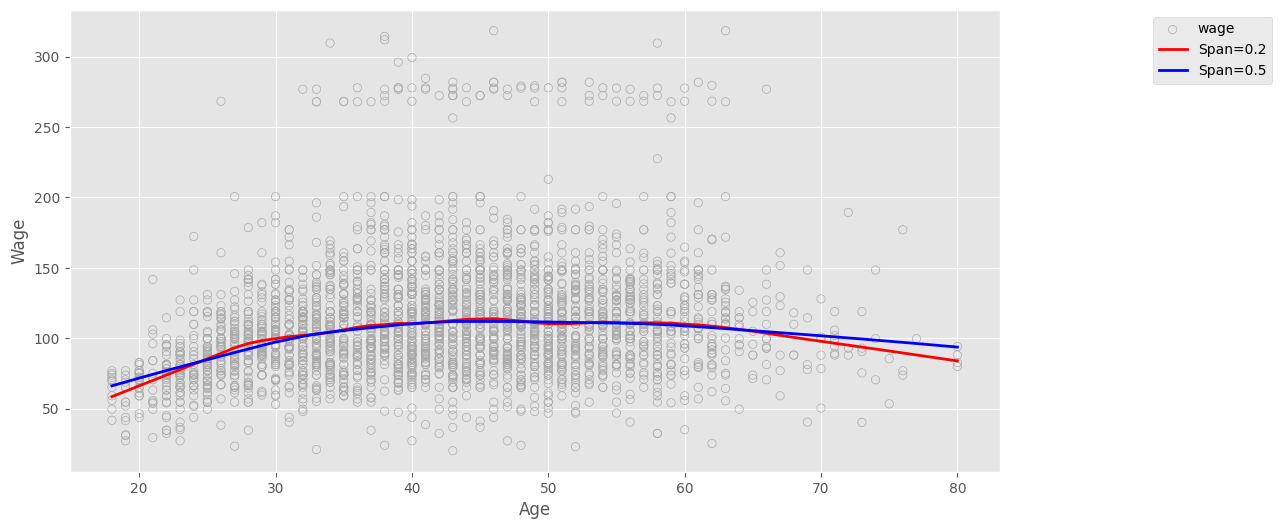

In [49]:
# Make Predictions using 20% and 50% spans #
############################################
# Note delta is 0. Delta is the distance to use linear interpolation rather than WLS. In the ISLR algorithm we
# always use WLS with no interpolation.
predictions20 = lowess(Wages.wage, Wages.age, frac=0.2, delta=0)
predictions50 = lowess(Wages.wage, Wages.age, frac=0.5, delta=0)

# Plot Data #
#############
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(Wages.age, Wages.wage,facecolors='none', edgecolors='darkgray', label="wage");
ax.plot(np.sort(Wages.age), predictions20[:,1], 'r-', lw=2, label='Span=0.2')
ax.plot(np.sort(Wages.age), predictions50[:,1], 'b-', lw=2, label='Span=0.5')

# Labels
ax.set_xlabel('Age')
ax.set_ylabel('Wage');
plt.legend(bbox_to_anchor=(1.3, 1.0));

### GAMs for Regression Problems

- **Generalized Additive Models (GAM)** are a large linear regression onto spline basis variables. 

- To perform a **GAM regression** we simply need to create one large design matrix using basis splines for each feature of the model. 

- Patsy can design matrices representing B-splines, natural splines and cyclic splines but NOT smoothing splines since these are not represented as a set of basis functions. This is not a problem since we know that smoothing splines are equivalent to natural splines (shrunken versions). So to build a GAM we will use the natural spline basis representation.

Note: Patsy ( http://patsy.readthedocs.io/en/latest/spline-regression.html ) is an api to construct B-splines.

In [50]:
# Build Patsy Design Matrix #
#############################
# Build one large design matix constructed from natural splines for year (referred to here as f1) (dof=4) and 
# age (referred to here as f2) (dof=5) and add education categorical. NOTE constraints='center' is the default of
# R's GAM library. It forces the smooth functions f1(year), f2(age) to have zero mean. 
# See [ ftp://cran.r-project.org/pub/R/web/packages/mgcv/mgcv.pdf ] page 60.

design = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education",
                 data={"year":Wages.year, "age":Wages.age, "education":Wages.education}, return_type="dataframe")

# Fit Statsmodels OLS #
########################
# Again a GAM is just one large linear regression onto splines basis funcs so just construct an OLS model.
gam = sm.OLS(endog=Wages.wage, exog=design).fit()

In [51]:
print(gam.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     95.22
Date:                Wed, 25 Oct 2023   Prob (F-statistic):          1.55e-213
Time:                        16:22:10   Log-Likelihood:                -14930.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2986   BIC:                         2.997e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Now that we have constructed and fit the GAM, we need to figure out how to recover the smooth functions f1 and f2. The parameters of the GAM model are the coeffecients for all the spline basis functions fit simultaneously by OLS's fit method. So if we take the dot product of the coeffecients with the matching basis functions that make up f1 and f2 from the design matrix then we recover f1 and f2.

In [52]:
# Get the coeffecients for the year basis functions
gam.params[5:9]

cr(year, df=4, constraints='center')[0]   -0.054821
cr(year, df=4, constraints='center')[1]    3.619381
cr(year, df=4, constraints='center')[2]    2.293793
cr(year, df=4, constraints='center')[3]    4.534247
dtype: float64

In [53]:
# Lets take a look again at the design matrix
design.head(2)

,Intercept,education[T.2. HS Grad],education[T.3. Some College],education[T.4. College Grad],education[T.5. Advanced Degree],"cr(year, df=4, constraints='center')[0]","cr(year, df=4, constraints='center')[1]","cr(year, df=4, constraints='center')[2]","cr(year, df=4, constraints='center')[3]","cr(age, df=5, constraints='center')[0]","cr(age, df=5, constraints='center')[1]","cr(age, df=5, constraints='center')[2]","cr(age, df=5, constraints='center')[3]","cr(age, df=5, constraints='center')[4]"
0,1.0,0.0,0.0,0.0,0.0,-0.163729,0.875408,-0.134574,-0.098130,-0.501258,-0.695111,-0.500457,-0.097924,-0.005629
1,1.0,0.0,0.0,1.0,0.0,0.589322,-0.388702,-0.208715,-0.187743,0.400144,-0.615868,-0.284361,-0.074217,-0.002268


In [54]:
# Now get the columns of the design matrix that correspond to the year basis functions evaluated at the year in that
# row of the dataframe.
year_basis = design[design.columns[5:9]]
year_basis.head(2)

,"cr(year, df=4, constraints='center')[0]","cr(year, df=4, constraints='center')[1]","cr(year, df=4, constraints='center')[2]","cr(year, df=4, constraints='center')[3]"
0,-0.163729,0.875408,-0.134574,-0.098130
1,0.589322,-0.388702,-0.208715,-0.187743


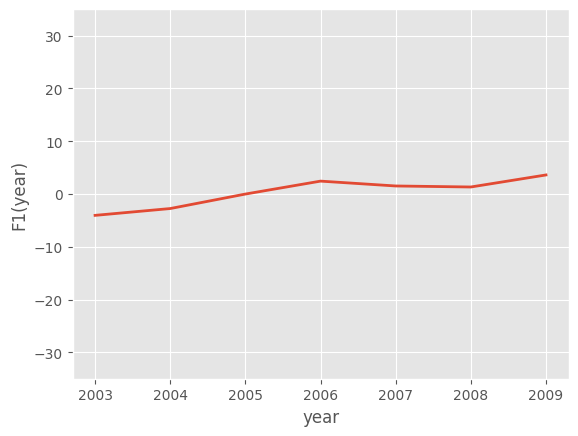

In [55]:
# The last step is to mulitply the coeffecients by the year basis functions f1(year) = basis_funcs * Betas
# Get the order of the years index
order = np.argsort(Wages.year.values)
# Plot F1(year)
plt.plot(Wages.year[order],np.dot(year_basis.values, gam.params[5:9])[order], lw=2)
plt.ylim([-35,35]);
labels = list(range(2003,2010,1))
plt.xticks(range(2003,2010), labels);
plt.xlabel('year');
plt.ylabel('F1(year)');

Now lets do the same with the age basis functions and coeffecients from the GLM fit.

In [56]:
# Get the age_basis functions evaluated at the age in each row of the dataframe.
age_basis = design[design.columns[9:]]
age_basis.head(1)

,"cr(age, df=5, constraints='center')[0]","cr(age, df=5, constraints='center')[1]","cr(age, df=5, constraints='center')[2]","cr(age, df=5, constraints='center')[3]","cr(age, df=5, constraints='center')[4]"
0,-0.501258,-0.695111,-0.500457,-0.097924,-0.005629


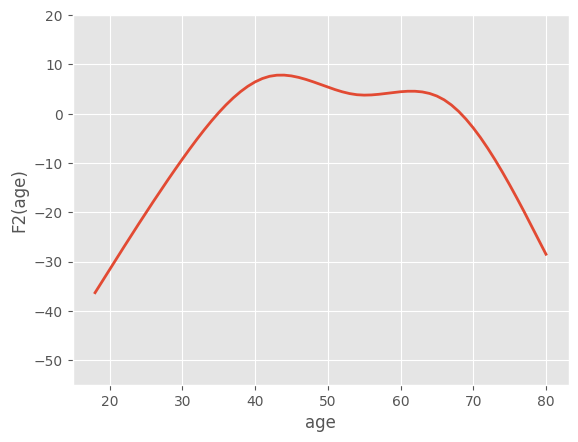

In [57]:
# Plot the ages and F2(ages)
# get the ages order index
order = np.argsort(Wages.age.values)
# again dot the coeffecients and the age basis functions
plt.plot(Wages.age[order], np.dot(age_basis.values, gam.params[9:])[order], lw=2);
plt.ylabel('F2(age)');
plt.xlabel('age');
plt.ylim([-55,20]);

In [58]:
# Now get the columns of the design matrix that correspond to the education levels
ed_levels = design[design.columns[1:5]].copy()

# get the coeffecients
ed_coeffs = gam.params[1:5];

# add the dot product of the ed-levels and coeffs to the Wages dataframe. Renmeber to center to mean to be
# consistent with R's gam plotting library
Wages['ed_F3'] = np.dot(ed_levels, ed_coeffs)
Wages['ed_F3'] = Wages['ed_F3']-Wages['ed_F3'].mean()
Wages.head(2)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,high_earner,ed_F3
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0.0,-26.227696
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,0.0,12.005255


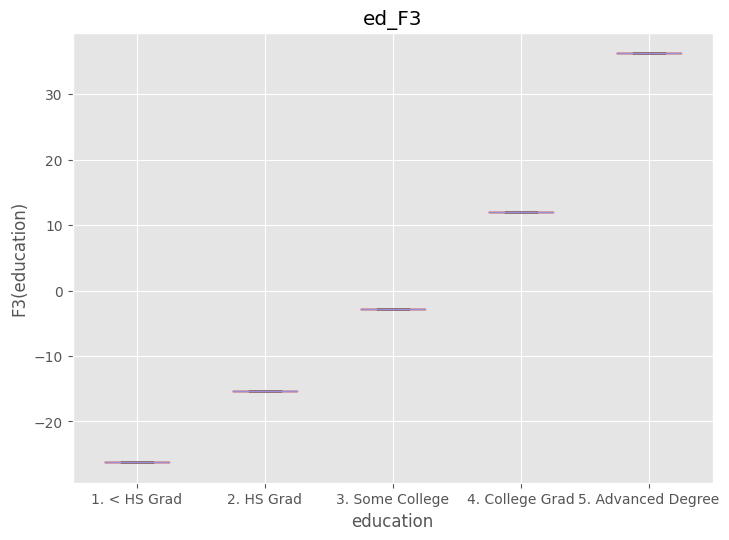

In [59]:
#boxplot the F3(ed) grouped by ed-level 
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
Wages.boxplot(column='ed_F3', by='education', ax=ax1);
ax1.set_ylabel('F3(education)');
plt.suptitle('');

So to recap, we built a GAM using natural splines rather than smoothing splines used in the lab but we get the same results since smoothing splines are shrunken versions of natural splines. 

In general this approach is flexible and limited only by the basis functions provided by patsy (B-Splines, Nat. Splines, Cyclic Splines).

## ANOVA Test

From the plot of the year above we can see that the natural spline function is rather linear, so lets build a set
of models and compare them using the F-Statistic.

In [60]:
# Design matrix and gam without year variable
design1 = dmatrix("cr(age, df=5, constraints='center') + education",
                 data={"age":Wages.age, "education":Wages.education}, return_type="dataframe")

gam1 = sm.OLS(endog=Wages.wage, exog=design1).fit()

# Design matrix and GAM Linear in year
design2 = dmatrix("year + cr(age, df=5, constraints='center') + education",
                 data={"year":Wages.year, "age":Wages.age, "education":Wages.education}, return_type="dataframe")

gam2 = sm.OLS(endog=Wages.wage, exog=design2).fit()

# Design matrix and GAM with a natural spline of year of dof=4
design3 = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education",
                 data={"year":Wages.year, "age":Wages.age, "education":Wages.education}, return_type="dataframe")

gam3 = sm.OLS(endog=Wages.wage, exog=design3).fit()

# ANOVA TEST
anova = sm.stats.anova_lm(gam1, gam2, gam3)
print(anova)

   df_resid           ssr  df_diff       ss_diff          F    Pr(>F)
0    2990.0  3.712549e+06      0.0           NaN        NaN       NaN
1    2989.0  3.695015e+06      1.0  17534.011180  14.182511  0.000169
2    2986.0  3.691628e+06      3.0   3386.677223   0.913113  0.433717


So the linear model is better than the model with no year but their is no evidence (p = 0.433) that a natural spline improves the model.

In [61]:
# Lastly lets print the summary of the GAM2 linear in year variable
print(gam2.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     123.5
Date:                Wed, 25 Oct 2023   Prob (F-statistic):          4.70e-216
Time:                        16:22:27   Log-Likelihood:                -14931.
No. Observations:                3000   AIC:                         2.988e+04
Df Residuals:                    2989   BIC:                         2.995e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

So we see clear evidence for a nonlinear term in age but not in year. We can use the same techniques and functions above to also do a logistic regression using natural splines. It is identical to the previous analysis so I have left it undone.

Nt: Hence we refit the GAM, excluding the individuals with less than a high school education.